In [197]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR, SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
%matplotlib inline

## Próba reakreowania statystyk z https://arxiv.org/pdf/1706.00948.pdf

Zbiór df zawiera wszystkie wskaźniki techiczne wymienione w artykule. Tam gdzie autorzy nie podali parametrów stosowałem te domyślnie. Przy tworzeniu wskaźników korzystałem z biblioteki TALIB.

In [198]:
df = pd.read_csv("/home/olaf/Finanse/spx_ta.csv", index_col=0)

y1 = df['target1']
y3 = df['target3']
y5 = df['target5']
X = df.drop(['target1','target3','target5'], axis=1)

Tworzymy 3 zmienne celu:
    1)Zwrot po 1 dniu
    2)Zwrot po 3 dniach
    3)Zwrot po 5 dniach

Najpierw wystandaryzujemy zbiór X

In [199]:
X = StandardScaler().fit_transform(X)

Nie będziemy korzystać z funkcji train_test_split z sklearnu ponieważ losuje ona zbiór testowy, a my do testów chcemy zbiór, taki móc sprawdzić jak model radzi sobie z danymi, których wcześniej nie widział(nowy przedział czasowy)

In [200]:
def train_test(X,y, size):
    X_train = X[:-size,]
    X_test = X[-size:,]
    y_train = y[:-size]
    y_test = y[-size:]
    return X_train, X_test, y_train, y_test

Zdefiniujemy sobie funkcję, która rysuje Precision-Recall curve i liczy pole pod jej powierzchnią i będziemy z niej korzystać by oceniać jakość modeli.

In [201]:
def p_r_curve(y_test, preds, thresh = 10):
    probas = MinMaxScaler().fit_transform(preds.reshape(-1,1))
    p, r, t = precision_recall_curve(y_test > thresh, probas)
    plt.step(r,p)
    plt.fill_between(r, p, step='post', alpha=0.2,
                 color='b')
    print(auc(r,p))

In [202]:
X_train, X_test, y_train, y_test = train_test(X,y5, 1500)

Będziemy sprawdzać 3 modele:
<br>
1)SVM
<br>
2)Random Forest
<br>
3)Xgboost

In [203]:
svr = SVR(kernel="poly")
svr.fit(X_train, y_train)
preds = svr.predict(X_test)

0.576173397057


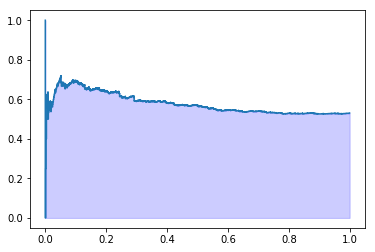

In [204]:
p_r_curve(y_test, preds, 5)

In [205]:
rf = RandomForestRegressor(n_estimators=100, max_depth=3)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

0.587406734442


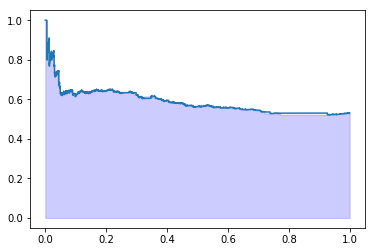

In [206]:
p_r_curve(y_test, preds, 5)

In [207]:
xgr = XGBRegressor()
xgr.fit(X_train, y_train)
preds = xgr.predict(X_test)

0.547995618041


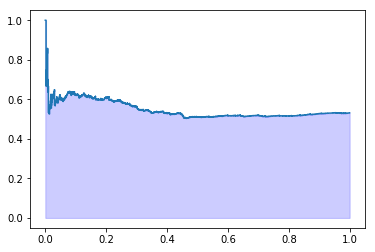

In [208]:
p_r_curve(y_test, preds, 5)

Spróbujmy zrobić ensemble modeli by zwiększyć ich skuteczność

In [209]:
preds_svr = MinMaxScaler().fit_transform(svr.predict(X_test).reshape(-1,1))

In [210]:
preds_rf = MinMaxScaler().fit_transform(rf.predict(X_test).reshape(-1,1))

In [211]:
preds_xgb = MinMaxScaler().fit_transform(xgr.predict(X_test).reshape(-1,1))

In [212]:
preds = preds_svr  + preds_xgb + preds_rf
preds = preds/3

In [213]:
p, r, t = precision_recall_curve(y_test > 3, preds)

0.562912510173


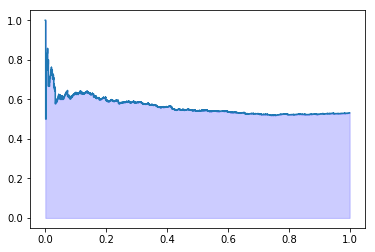

In [214]:
p_r_curve(y_test, preds,5)

Zobaczmy jak wygląda średni zysk po stosowaniu różnych wartośći thresholdu na wartości

In [215]:
zyski = []
for tresh in t:
    zyski.append(y_test.values.reshape(-1,1)[preds>tresh].mean())
trials = []
for tresh in t:
    trials.append(len(y_test.values.reshape(-1,1)[preds>tresh]))

/home/olaf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/olaf/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


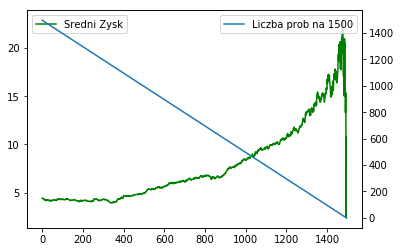

In [216]:
plt.plot(zyski, c='green', label="Sredni Zysk")
plt.legend()
plt.twinx()
plt.plot(trials, label="Liczba prob na 1500")
plt.legend()